# Probabilistic Planning with MDP


## The confused traveler

Imagine an traveler who wants to drive from a city in the northwest to another one in the northeast. However, it turns out that the traveler forgot his GPS device and all of his printed maps (compared to the lucky guy in the picture below). Our traveler has to completely rely on the street signs in the cities. Unfortunately for him, the signs are much more confusing in the north than in the south. Therefore, it is likelier for him to take the wrong route in the northern part of the country. Given this, the agent wonders what his best strategy is to get from one city to the other while minimizing the distance he needs to go. 

<img src=confused_traveler.jpg>

Let's start by providing him with some helpful imports to start with:

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Modules
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt

# Classes
from graph import Graph, Edge
from search_classes import SearchNode, Path
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction and problem statement

Before we think about which algorithm we can use to help our traveler, let's model the map that he travels on. To keep things familiar, we will use a derived version of the romania graph. Compared to the original map, we added some additional connections and the weight for each edge is now the euclidian distance between two cities, i.e. the distance our traveler needs to travel. 

Our traveler starts in city 'O' and wants to go to 'N'.

To encode the bad street signs in the north, we made a linear probability distribution between the southmost city 'G' and the northmost city 'O'. We visualized this by coloring the cities from red to green, where red is a high probability of taking the wrong road vice versa for green. 

Execute the following cell to get the graph plotted!

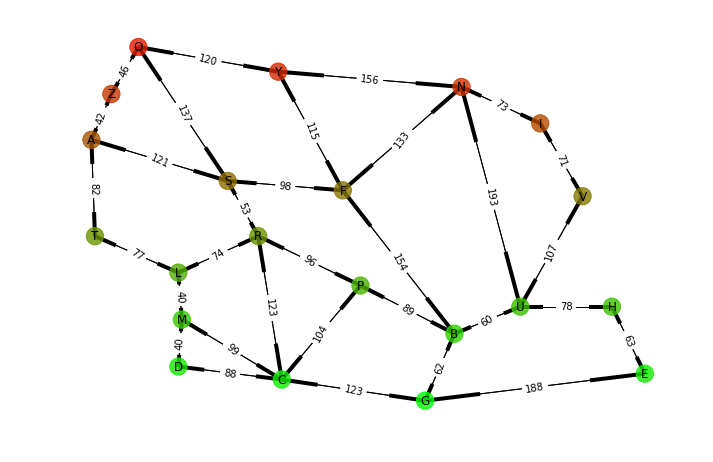

In [4]:
# x,y positions of Romania's cities
romania_locations = dict(
    A=(91, 492), B=(400, 327), C=(253, 288), D=(165, 299),
    E=(562, 293), F=(305, 449), G=(375, 270), H=(534, 350),
    I=(473, 506), L=(165, 379), M=(168, 339), N=(406, 537),
    O=(131, 571), P=(320, 368), R=(233, 410), S=(207, 457),
    T=(94, 410), U=(456, 350), V=(509, 444), Z=(108, 531), Y=(250, 550))

# Initialize connections
romania_connections = dict(
    A=dict(Z=1, S=1, T=1),
    B=dict(U=1, P=1, G=1, F=1),
    C=dict(D=1, R=1, P=1, G=1),
    D=dict(C=1, M=1),
    E=dict(H=1, G=1),
    F=dict(B=1, S=1, N=1, Y=1),
    G=dict(B=1, C=1, E=1),
    H=dict(E=1, U=1),
    I=dict(V=1, N=1),
    L=dict(T=1, M=1, R=1),
    M=dict(C=1, L=1),
    N=dict(F=1, I=1, U=1, Y=1),
    O=dict(Z=1, S=1, Y=1),
    P=dict(B=1, C=1, R=1),
    R=dict(C=1, L=1, S=1, P=1),
    S=dict(A=1, F=1, O=1, R=1),
    T=dict(A=1, L=1),
    U=dict(B=1, H=1, V=1, N=1),
    V=dict(I=1, U=1),
    Z=dict(A=1, O=1),
    Y=dict(O=1, N=1, F=1),
)

# Updates weights with euclidean distance
for connections in romania_connections:
    for destination in romania_connections[connections]:
        romania_connections[connections][destination] = int(
            eucl_dist(romania_locations[connections], romania_locations[destination]))

romania_graph = Graph()

romania_graph.set_node_positions(romania_locations)
for location1 in romania_connections:
    for location2 in romania_connections[location1]:
        romania_graph.add_edge(location1, location2, romania_connections[location1][location2])
        
# Probability of taking the right road
def get_prob(romania_locations, prob_G, prob_O):
    romania_correct_turn = dict()
    for location in romania_locations:
        romania_correct_turn[location] = prob_O + (romania_locations[location][1] - romania_locations['O'][1]) * \
                                         ((prob_O - prob_G) / (romania_locations['O'][1] - romania_locations['G'][1]))
    return romania_correct_turn

romania_correct_turn = get_prob(romania_locations, prob_G = 1, prob_O = 0.1)


# Draw the map
romania_graph.draw(color_keys=romania_correct_turn)

## Encoding the graph as a MDP

To help the traveler, we recall some of the tools we learned in 16.413. After intense discussion what the most appropriate encoding would be, we agreed to start with a MDP and setup a function that builds the MDP from the graph above. Specifically, we encoded
- cities as **states**,
- the route the traveler wants to take as **actions**,
- the probabilites to end up in the desired city or another one with the **transition** dictionary,
- and the reward when reaching the destination and the travel distance as **reward** dictionary.

Let's build the MDP:

In [5]:
# Build the MDP
def build_mdp(romania_locations, romania_connections, romania_correct_turn, goal_dict):
    # States
    S = set(location for location in romania_locations)

    # Actions
    A = dict()
    for s in S:
        location = s[0]
        if location in goal_dict:
            A[s] = [location]
        else:
            A[s] = [destination for destination in romania_connections[location]]

    # Transitions
    T = dict()
    for s in S:
        T[s] = dict()
        for action in A[s]:
            T[s][action] = dict()
            for destination in romania_connections[s]:
                if destination == action:
                    T[s][action][destination] = romania_correct_turn[s]
                else: # Split the other prob evenly over the remaining nodes
                    T[s][action][destination] = (1 - romania_correct_turn[s])/(len(romania_connections[s])-1)

    # Reward
    R = dict()
    for location in T:
        R[location] = dict()
        for action in T[location]:
            R[location][action] = dict()
            for destination in T[location][action]:
                if action in goal_dict:
                    R[location][action][destination] = goal_dict[action]
                else:
                    R[location][action][destination] = - romania_connections[location][destination]  # travel cost

    gamma = 0.9

    return MDP(S, A, T, R, gamma)

## Get the optimal policies by value iteration

After you have encoded the problem, you finally can write some algorithm to help out our traveler. Since the traveler is really confused, you want to give him an optimal policy for each city that he might be in. Remembering one of the problem sets, you want to reuse your code and decide to try value iteration. After running the value iteration, you also try to find for the traveler a plan to get from his start city 'O' to his destination 'N'.

To avoid any more confusion of our traveler, we give him a textual description of the optimal policies as well as a graphical depiction of where he needs to go.

Let's see what we get:

The value iteration needed 139 iterations to converge
For A best choice is S
For B best choice is U
For C best choice is G
For D best choice is C
For E best choice is H
For F best choice is N
For G best choice is B
For H best choice is U
For I best choice is N
For L best choice is M
For M best choice is C
For N best choice is N
For O best choice is Z
For P best choice is B
For R best choice is P
For S best choice is F
For T best choice is L
For U best choice is N
For V best choice is I
For Y best choice is N
For Z best choice is A


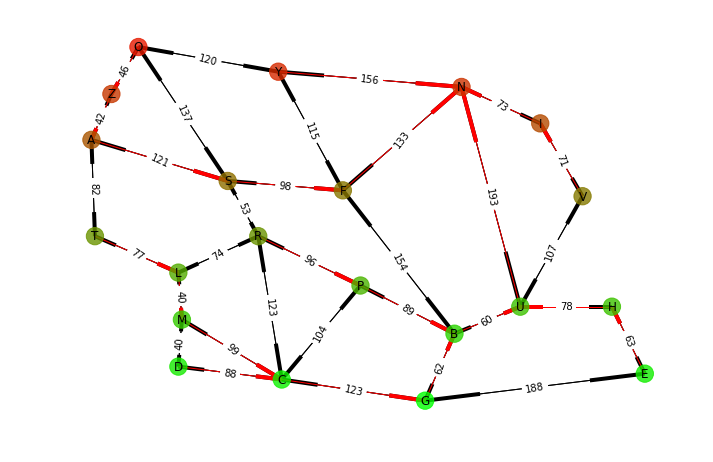

Optimal path: ['O', 'Z', 'A', 'S', 'F', 'N']


In [6]:
def build_mdp_and_get_policies(start, goal_dict):
    # Build mdp
    mdp = build_mdp(romania_locations, romania_connections, romania_correct_turn, goal_dict)

    # Value iteration and extract policies
    v = value_iteration(mdp, epsilon=1e-3)
    Pi = extract_policy(mdp, v)
    return Pi

def visualize_optimal_policy():
    # Print
    for p in sorted(Pi):
        print("For " + p + " best choice is " + Pi[p])

    # Draw optimal policies
    romania_graph.draw(highlight_edges=[(p, Pi[p]) for p in Pi], color_keys=romania_correct_turn)

    # Get optimal path
    def get_optimal_path(start, Pi):
        goal_found = False
        path = [start]
        while True:
            if path[-1] in goal_dict:
                break
            path.append(Pi[path[-1]])
            if len(path) > len(Pi):
                path = "no path found"
                break
        return "Optimal path: " + str(path)
    print(get_optimal_path(start, Pi))
    
    
# Init parameters
goal_dict = dict(N=100)
start = 'O'

# Run functions
Pi = build_mdp_and_get_policies(start, goal_dict)
visualize_optimal_policy()

Surprised? Have you expected that? 

Apparently, the obvious shortest path in the north 'O' -> 'Y' -> 'N' is not optimal. It seems the signs are so bad in the north that the probability is very high that the traveler actually ends up in the different city than he wanted to, and therefore accumulates negative rewards (i.e. travelled distance). It will be better for him to do an extra turn to go to the south, where he can be sure that he will make progress and then go back up again. 

You can use the cell below to play around yourself with different combinations of starts, goals, and rewards for the goal

The value iteration needed 112 iterations to converge
For A best choice is T
For B best choice is U
For C best choice is G
For D best choice is C
For E best choice is H
For F best choice is B
For G best choice is B
For H best choice is U
For I best choice is V
For L best choice is M
For M best choice is C
For N best choice is Y
For O best choice is S
For P best choice is B
For R best choice is P
For S best choice is R
For T best choice is L
For U best choice is V
For V best choice is V
For Y best choice is O
For Z best choice is O


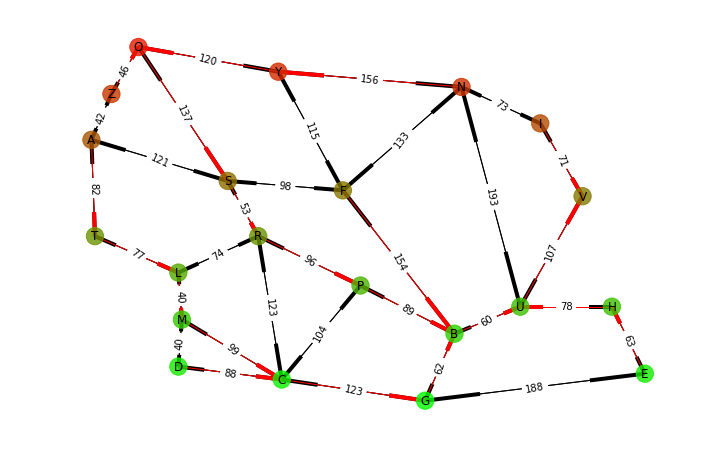

Optimal path: ['T', 'L', 'M', 'C', 'G', 'B', 'U', 'V']


In [7]:
# Code for you to play around with different starts, goals and rewards for reaching the goal

# Init parameters
goal_dict = dict(V=100)
start = 'T'

# Run functions
Pi = build_mdp_and_get_policies(start, goal_dict)
visualize_optimal_policy()

You are about to deliver this result to the traveler when you run into an old friend from the north. You started to talk about this project and he cannot believe that the signs in the north are that bad. You argued for a while but finally he convinced you to investigate the effect of changing the probabilities more rigorous.

To bound the problem, you first want to find the threshold point where the traveler should choose the direct route from 'O' to 'N'. After playing around a bit, you see that this point is for a probability of 0.3 in the northmost city 'O' (you can try this yourself in the cell below). With this data you can convince your friend from the north that the signs are definitely that bad and the best choice for the traveler is indeed to 

The value iteration needed 88 iterations to converge
For A best choice is S
For B best choice is U
For C best choice is G
For D best choice is C
For E best choice is H
For F best choice is N
For G best choice is B
For H best choice is U
For I best choice is N
For L best choice is R
For M best choice is C
For N best choice is N
For O best choice is Z
For P best choice is B
For R best choice is S
For S best choice is F
For T best choice is L
For U best choice is N
For V best choice is I
For Y best choice is N
For Z best choice is A


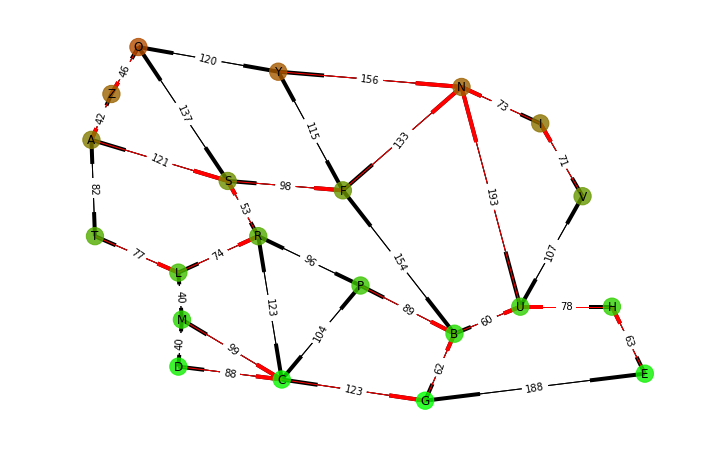

Optimal path: ['O', 'Z', 'A', 'S', 'F', 'N']


In [8]:
# Use this to update your belief about the probabilities
# try to prob_O = 0.4 to see the policy changing
romania_correct_turn = get_prob(romania_locations, prob_G = 1, prob_O = 0.3)  

# Init parameters
goal_dict = dict(N=100)
start = 'O'

# Run functions
Pi = build_mdp_and_get_policies(start, goal_dict)
visualize_optimal_policy()

## Delivery

After the discussion with your friend, you become much more confident in the usefulness of your tool. When you meet with the confused traveler and show him the work you did, he is more than pleased. He right away begins his journey and now always has a perfect policy for each city. A few days later he sends you a picture from him reaching his destination and thanks you again for your hard work. Furthermore, you found out that he updated the probabilistic distribution map with his experience as he travelled along. As you now want to commercialize your idea, you already start about the next steps and how you can update those beliefs as more travelers will use your tool...

<img src=happy-traveler.jpg>